# Solución del análisis cinemático inverso del Robot Manipulador Paralelo tipo Delta

La teoría abordada en este cuaderno se describe aquí: 

**https://nbviewer.jupyter.org/github/luismiguelaristi/MecanismosPythonUPB/blob/main/Delta/RobotDelta_Teoria.ipynb**

En la imagen podemos observar la posición inicial del robot Delta de la UPB. Esta posición corresponde a los ángulos de los tres motores $\theta = -23.5°$. A esta posición se le llama HOME.

Realizando mediciones en el modelo CAD del robot Delta de la UPB, se obtuvieron los siguientes parámetros y condiciones iniciales:

Parámetros

$r = 144.34$ mm

$a = 200.87$ mm

$b = 526.69$ mm

$h = 50$ mm

$\phi1 = 30°$

Variables de entrada:

$P = [0,0,-528.67]$ mm

Condiciones iniciales: 

$Q = [284.53,164.27,-80.09]$ mm

Con esto se tiene información suficiente para resolver el problema de la cinemática inversa de este robot.

Partimos de las ecuaciones que modelan la geometría de éste en función del punto Q:

\begin{equation}
\label{eq:esfera1}
(Q_x - D_x)^2+(Q_y - D_y)^2+(Q_z - D_z)^2 = a^2
\end{equation}

\begin{equation}
\label{eq:esfera2}
(Q_x - C_x)^2+(Q_y - C_y)^2+(Q_z - C_z)^2 = b^2
\end{equation}

\begin{equation}
\label{eq:plano}
Q_x cos(\phi + 90°)+Q_y sin(\phi + 90°) = 0
\end{equation}

considerando que

$D_x = rcos(\phi)$, $D_y = rsin(\phi)$, $D_z = 0$, $C_x = P_x + hcos(\phi)$, $C_y = P_y + hsin(\phi)$ y $C_z = Pz$.

Al resolver este sistema de ecuaciones tendremos la ubicación del punto $Q$ para una cadena cinemática. 

**Se debe repetir el proceso para las demás cadenas considerando las diferencias que hay entre cada una, i.e., la orientación $\phi$ y las condiciones iniciales.**

## Solución por métodos numéricos

Para resolver este sistema de ecuaciones utilizaremos métodos numéricos, como se muestra a continuación.

### Limpiar entorno

Esto es útil durante la etapa de desarrollo del código, para evitar problemas con variables en memoria que no estemos manejando.

In [1]:
## magia de IPython para limpiar variables del entorno, REQUIERE IPython
%reset -sf
%matplotlib inline

### Importar módulos

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
#para realizar animaciones
from matplotlib.animation import FuncAnimation
#para gráficas 3D
from mpl_toolkits.mplot3d import Axes3D

### Definir función

In [3]:
def fn_delta(condIni,params):
    #Vars. de entrada
    px = params[0]
    py = params[1]
    pz = params[2]
    #parametros
    a =  params[3]
    b =  params[4]
    h =  params[5]
    r =  params[6]
    phi1= params[7]
    
    Qx = condIni[0]
    Qy = condIni[1]
    Qz = condIni[2]
    
    Dx = r*np.cos(phi1);
    Dy = r*np.sin(phi1);
    Dz = 0;
    Cx = px + h*np.cos(phi1);
    Cy = py + h*np.sin(phi1);
    Cz = pz;
    
    Y = np.zeros(3)
    Y[0] = (Qx-Dx)**2 + (Qy-Dy)**2 + (Qz-Dz)**2 - a**2
    Y[1] = (Qx-Cx)**2 + (Qy-Cy)**2 + (Qz-Cz)**2 - b**2
    Y[2] = Qx*np.cos(phi1 + (np.pi/2)) + Qy*np.sin(phi1 + (np.pi/2))
    return Y

### Probar función

In [4]:
# Posición HOME del robot, theta = 23.5°

px = 0;
py = 0;
pz = -528.6718

#eje motores a eje paralelogramo superior (esf?ricos)
a=200.87
#longitud paralelogramo
b=526.695
#distancia eje paralelogramo inferior (esf?ricos) a centro de la base m?vil
h= 52.528
#base fija a eje motores [mm]
r=144.34 

phi1 = np.deg2rad(30)
phi2 = phi1 + np.deg2rad(120)
phi3 = phi1 + np.deg2rad(240)

Qx_ini1 = 284.5325
Qy_ini1 = 164.2749
Qz_ini1 = -80.0967
th1_ini = np.deg2rad(-23.5)
d = r + a*np.cos(th1_ini)
Qx_ini2 = d*np.cos(phi2)
Qy_ini2 = d*np.sin(phi2)
Qz_ini2 = Qz_ini1
Qx_ini3 = d*np.cos(phi3)
Qy_ini3 = d*np.sin(phi3)
Qz_ini3 = Qz_ini1

x01 = [Qx_ini1,Qy_ini1,Qz_ini1]
x02 = [Qx_ini2,Qy_ini2,Qz_ini2]
x03 = [Qx_ini3,Qy_ini3,Qz_ini3]

phiv = [phi1,phi2,phi3]
x0m = [x01,x02,x03]

parametros = [px,py,pz,a,b,h,r,phi1]
print(fn_delta(x01,parametros))
parametros = [px,py,pz,a,b,h,r,phi2]
print(fn_delta(x02,parametros))
parametros = [px,py,pz,a,b,h,r,phi3]
print(fn_delta(x03,parametros))

[-1.65848887e-02  4.41989296e-02 -1.33958517e-05]
[-4.08092979e-03  6.29349850e-02  2.84217094e-14]
[-4.08092981e-03  6.29349850e-02  2.01178765e-14]


### Resolver el sistema para las condiciones iniciales y definición de puntos C y D

In [5]:
Qx,Qy,Qz = np.zeros(3),np.zeros(3),np.zeros(3)
Cx,Cy,Cz = np.zeros(3),np.zeros(3),np.zeros(3)
Dx,Dy,Dz = np.zeros(3),np.zeros(3),np.zeros(3)
for i in range(0,3):
    parametros = [px,py,pz,a,b,h,r,phiv[i]]
    x0 = x0m[i]
    q,info,exitflag,mensaje = fsolve(fn_delta,x0,args = parametros,full_output = True)
    print("Condiciones iniciales = ",x0)
    print("solucion = ",q,"\n",exitflag,"\n",mensaje)
    Qx[i] = q[0]
    Qy[i] = q[1]
    Qz[i] = q[2]
    Dx[i] = r*np.cos(phiv[i])
    Dy[i] = r*np.sin(phiv[i])
    Dz[i] = 0
    Cx[i] = px + h*np.cos(phiv[i])
    Cy[i] = py + h*np.sin(phiv[i])
    Cz[i] = pz

Condiciones iniciales =  [284.5325, 164.2749, -80.0967]
solucion =  [284.53250942 164.27492091 -80.09676072] 
 1 
 The solution converged.
Condiciones iniciales =  [-284.53252269449484, 164.27492857087003, -80.0967]
solucion =  [-284.53250942  164.27492091  -80.09676072] 
 1 
 The solution converged.
Condiciones iniciales =  [-6.035362963634278e-14, -328.54985714173984, -80.0967]
solucion =  [-8.04715024e-14 -3.28549842e+02 -8.00967607e+01] 
 1 
 The solution converged.


## Gráficas en 3D

Vamos a implementar unos cuantos comandos para hacer que las gráficas en 3D se vean bien

### Graficar posición inicial

1. Creamos la figura
2. Cambiamos el tamaño de la ventana
3. Creamos los ejes con la característica de proyección 3d y vistas ortogonales para desactivar la perspectiva
4. Podemos cambiar la vista usando combinaciones de ángulos "elevación" y "azimut"

    vista iso = elev = 30°, azimut = 315°

    vista superior = elev = 90°, azimut = 270°

    vista frontal = elev = 0°, azimut = 270°
5. Graficamos los puntos
6. ajustamos los ejes, se requiere un factor de escala manual ya que mplot3d aún no implementa la escala de ejes

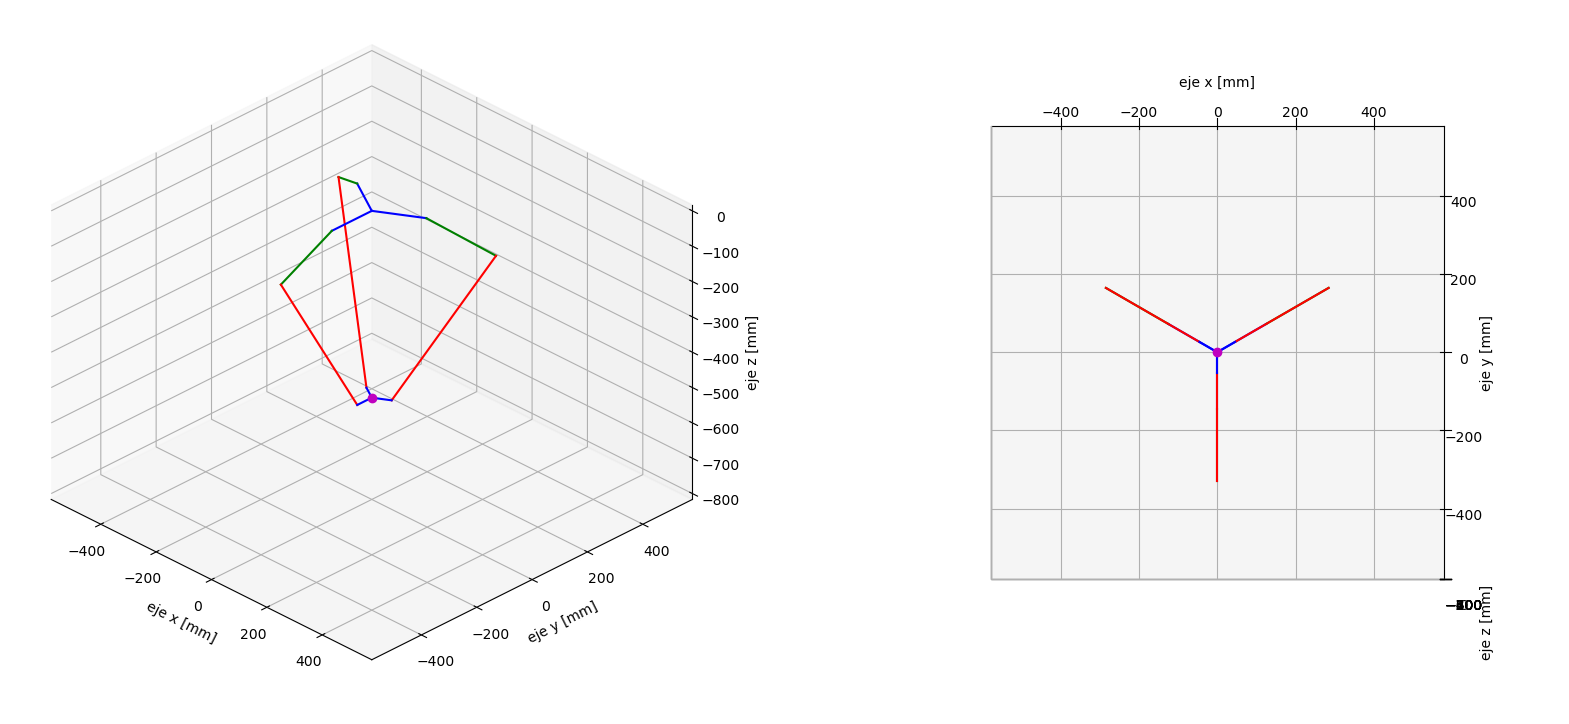

In [6]:
fig1 = plt.figure(figsize=(20, 10),
                  dpi = 100)
ax = [fig1.add_subplot(121,projection = '3d', proj_type = 'ortho'),
     fig1.add_subplot(122,projection = '3d', proj_type = 'ortho')
     ]


#crear listas con cualquier trio de elementos, luego se reemplazan con los plots correspondientes
h_a = [0,0,0,0,0,0]
h_b = [0,0,0,0,0,0]
h_h = [0,0,0,0,0,0]
h_P = [0,0]
for i in range(0,3):
    ax[0].plot([Dx[i],0],[Dy[i],0],[Dz[i],0],'-b')
    h_a[i] = ax[0].plot([Dx[i],Qx[i]],[Dy[i],Qy[i]],[Dz[i],Qz[i]],'-g')
    h_b[i] = ax[0].plot([Cx[i],Qx[i]],[Cy[i],Qy[i]],[Cz[i],Qz[i]],'-r')
    h_h[i] = ax[0].plot([Cx[i],px],[Cy[i],py],[Cz[i],pz],'-b')
for i in range(0,3):
    ax[1].plot([Dx[i],0],[Dy[i],0],[Dz[i],0],'-b')
    h_a[i+3] = ax[1].plot([Dx[i],Qx[i]],[Dy[i],Qy[i]],[Dz[i],Qz[i]],'-g')
    h_b[i+3] = ax[1].plot([Cx[i],Qx[i]],[Cy[i],Qy[i]],[Cz[i],Qz[i]],'-r')
    h_h[i+3] = ax[1].plot([Cx[i],px],[Cy[i],py],[Cz[i],pz],'-b')

# Vistas - Descomentar una
# Vista ISO
ax[0].view_init(elev=30, azim=315)
# # Vista lateral
ax[1].view_init(elev=90, azim=270)
# # Vista Superior
# ax.view_init(elev=90, azim=270)
    
for j in range(0,2):
    h_P[j] = ax[j].plot([px],[py],[pz],'mo',linewidth = 2)
    fEscala = 1.39
    ax[j].set_xlim3d(-400*fEscala,400*fEscala)
    ax[j].set_ylim3d(-400*fEscala,400*fEscala)
    ax[j].set_zlim3d(-800,0)
    ax[j].set_xlabel("eje x [mm]")
    ax[j].set_ylabel("eje y [mm]")
    ax[j].set_zlabel("eje z [mm]")

In [7]:
h_a

[[<mpl_toolkits.mplot3d.art3d.Line3D at 0x1c007ef8af0>],

### Solución para las otras cadenas cinemáticas

Actividad propuesta: ¿qué se debe definir para encontrar la posición de las otras dos cadenas?

pista: $\phi$ y $Q$

## Trayectorias

El objetivo del robot es realizar trabajos. Esto se logra desplazando el punto de interés P por el espacio, de manera que la herramienta que tenga de momento logre posicionarse donde se necesita. Esto en términos cinemáticos se traduce a definir trayectorias que el punto P debe recorrer.

Una trayectoria se compone de un conjunto de coordenadas sucesivas. Debemos especificar las trayectorias de manera que no haya una distancia muy amplia entre los puntos que la componen. 

Para más información sobre la construcción de trayectorias, revisar el siguiente cuaderno:

https://nbviewer.jupyter.org/github/luismiguelaristi/MecanismosPythonUPB/blob/main/Delta/RobotDelta_Trayectorias.ipynb

A continuación importaremos la última trayectoria generada desde dicho cuaderno, la cual quedó en el archivo "trayectoria":

In [8]:
import pickle
with open("trayectoria", "rb") as f:
    [[txv],[tyv],[tzv]] = pickle.load(f)

numpos = np.size(txv)

De manera alternativa podemos leer un archivo de texto con las posiciones x,y,z en formato csv, valores separados por comas.

In [9]:
tv = np.genfromtxt('Juliana_Posada _robotica.js', delimiter=',')
numpos = int(np.size(tv)/3)
txv = tv[:,0]
tyv = tv[:,1]
tzv = tv[:,2]
numpos,txv,tyv,tzv

(5,
 array([  0.,  20., -20., -20.,  20.]),
 array([  0.,  15.,  15., -15., -10.]),
 array([-600., -600., -600., -600., -600.]))

Grafiquemos la trayectoria

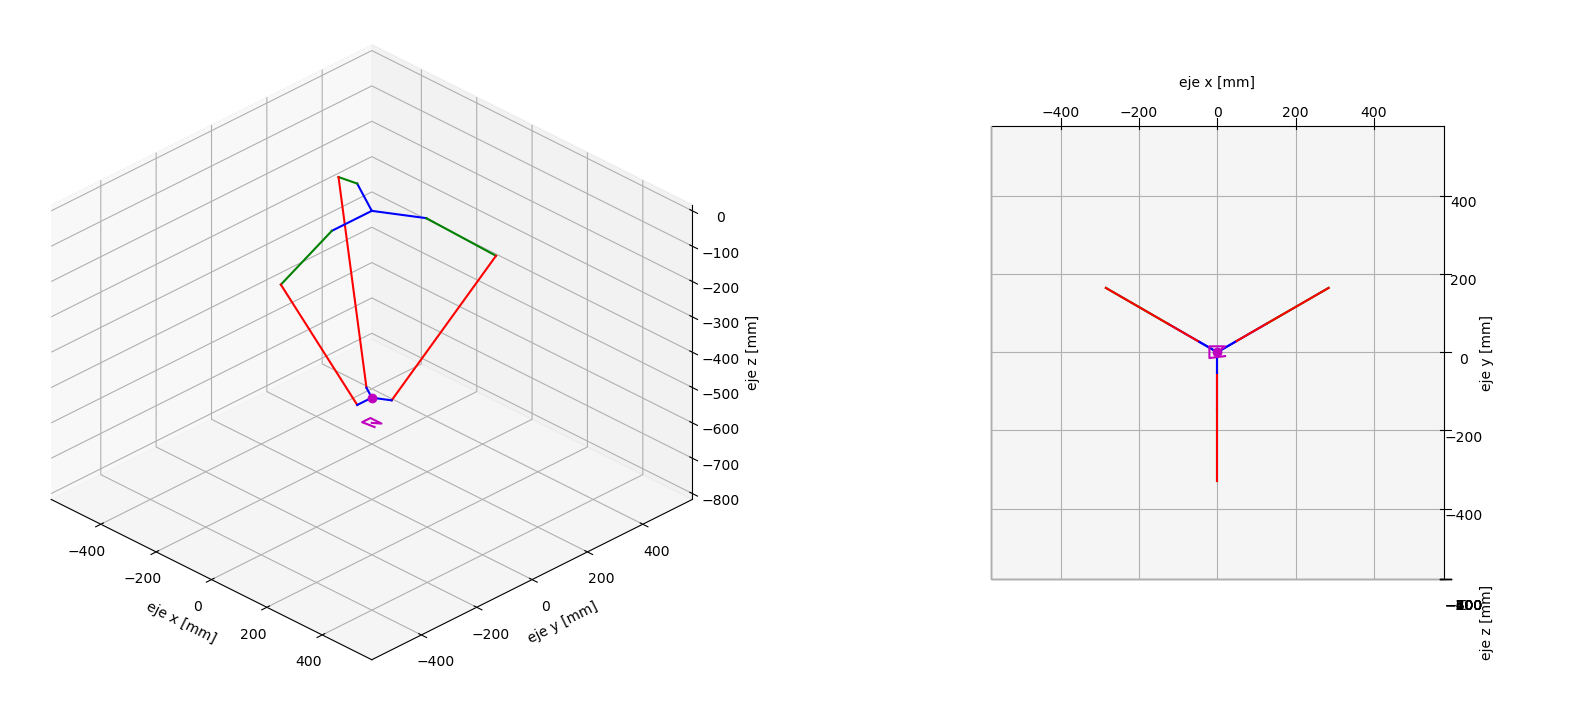

In [10]:
ax[0].plot(txv,tyv,tzv,'-m')
ax[1].plot(txv,tyv,tzv,'-m')

fig1

También debemos definir la posición de todos los puntos que se mueven en el mecanismo, es decir, los puntos $C$ y $Q$. El último lo debemos hallar con la solución de las ecuaciones, mientras que el primero es conocido ya que depende de $P$:

In [11]:
Cxm = np.transpose(np.array([ txv + h*np.cos(phiv[0]),txv + h*np.cos(phiv[1]),txv + h*np.cos(phiv[2])]))
Cym = np.transpose(np.array([ tyv + h*np.sin(phiv[0]),tyv + h*np.sin(phiv[1]),tyv + h*np.sin(phiv[2])]))
Czm = np.transpose(np.array([ tzv,tzv,tzv]))
Czm

array([[-600., -600., -600.],
       [-600., -600., -600.],
       [-600., -600., -600.],
       [-600., -600., -600.],
       [-600., -600., -600.]])

Luego resolvemos para todas las posiciones *numpos* de la trayectoria

In [12]:
EXITFLAG = np.zeros([numpos,3])
Qxm = np.zeros([numpos,3])
Qym = np.zeros([numpos,3])
Qzm = np.zeros([numpos,3])

for j in range(0,3):
    parametros = [px,py,pz,a,b,h,r,phiv[j]]
    x0 = x0m[j]
    for i in range(0,numpos):
        parametros[0] = txv[i]
        parametros[1] = tyv[i]
        parametros[2] = tzv[i]
        Y,info,EXITFLAG[i,j],msg = fsolve(fn_delta,x0,args = parametros,full_output = True)
        x0 = Y
        Qxm[i,j] = Y[0];
        Qym[i,j] = Y[1];
        Qzm[i,j] = Y[2];
        if EXITFLAG[i,j] != 1:
            print("Error en la iteración ",i," brazo ",j,". msg = ", msg)
            break

Qxm,Qym,Qzm

(array([[ 2.55695837e+02, -2.55695837e+02, -7.23159128e-14],
        [ 2.61956460e+02, -2.52651250e+02, -7.10486405e-14],
        [ 2.52651250e+02, -2.61956460e+02, -7.10486405e-14],
        [ 2.48466226e+02, -2.57997937e+02, -7.33573464e-14],
        [ 2.58733449e+02, -2.49243508e+02, -7.29998510e-14]]),
 array([[ 147.62606014,  147.62606014, -295.25212028],
        [ 151.24063264,  145.86826721, -290.07808839],
        [ 145.86826721,  151.24063264, -290.07808839],
        [ 143.45204253,  148.95517839, -299.50409566],
        [ 149.37982657,  143.90080663, -298.04451003]]),
 array([[-132.56805366, -132.56805366, -132.56805366],
        [-123.8551457 , -136.46618095, -138.23590884],
        [-136.46618095, -123.8551457 , -138.23590884],
        [-141.5070265 , -129.47935132, -127.56512188],
        [-128.46527789, -140.59702138, -129.32006997]]))

si todo salió bien, podemos proceder con la animación.

In [14]:
def animar(i):
    for j in range(0,6):
        brazo1_X = np.array([Dx[j%3],Qxm[i,j%3]])
        brazo1_Y = np.array([Dy[j%3],Qym[i,j%3]])
        brazo1_Z = np.array([Dz[j%3],Qzm[i,j%3]])
        antebrazo1_X = np.array([Cxm[i,j%3],Qxm[i,j%3]])
        antebrazo1_Y = np.array([Cym[i,j%3],Qym[i,j%3]])
        antebrazo1_Z = np.array([Czm[i,j%3],Qzm[i,j%3]])
        bmovil1_X = np.array([Cxm[i,j%3],txv[i]])
        bmovil1_Y = np.array([Cym[i,j%3],tyv[i]])
        bmovil1_Z = np.array([Czm[i,j%3],tzv[i]])
        h_a[j][0].set_data_3d([brazo1_X,brazo1_Y,brazo1_Z])
        h_b[j][0].set_data_3d([antebrazo1_X,antebrazo1_Y,antebrazo1_Z])
        h_h[j][0].set_data_3d([bmovil1_X,bmovil1_Y,bmovil1_Z])
    
    #h_P[j/3][0].set_data_3d([txv[i],tyv[i],tzv[i]])
    
    # Agregar los objetos gráficos a esta línea de return (evita error en spyder)
    return h_P[0][0],h_a[0][0],h_b[0][0],h_h[0][0]

videoLength = 5000 # en milisegundos
maxFrames = 80
increment = int(np.ceil(numpos/maxFrames))
totalFrames = range(0,numpos,increment)
animacion = FuncAnimation(fig1, animar, frames = totalFrames,
                          interval=videoLength/len(totalFrames), save_count=len(totalFrames),blit=True)

#En Jupyter se pueden mostrar las animaciones directamente en el cuaderno
from IPython.display import HTML

# Comentar para reducir tamaño del cuaderno, generar animación en formato gif o mp4, requiere instalar ffmpeg
#animacion.save('animation.mp4', writer='ffmpeg', fps=15)
HTML(animacion.to_jshtml())
#animacion.save('animation.gif', writer='Pillow', fps=15)

## Exportar ángulos para programación de robot

¿Cómo encontrar el ángulo $\theta$ si se conoce la ubicación del punto $Q$?

$\theta = sin^{-1}(\frac{Q_z}{a})$

Ahora aplicamos esto a los tres brazos, para así hallar $\theta_1,\theta_2$ y $\theta_3$.

Nota: deben especificarse en grados para poder ser ingresados al programa del robot real.

In [ ]:
th1v = np.rad2deg(np.arcsin(Qzm[:,0]/a))
th2v = np.rad2deg(np.arcsin(Qzm[:,1]/a))
th3v = np.rad2deg(np.arcsin(Qzm[:,2]/a))

datos = np.transpose([th1v,th2v,th3v])
#.csv - archivo de valores separados por comas (comma separated values)
np.savetxt("angulos.csv", datos,fmt='%.3f', delimiter=",")
datos

## Verificación de límites

Se debe verificar que los ángulos $\theta_1,\theta_2$ y $\theta_3$ No excedan los limites [-85°,-20°]

In [ ]:
fig2,ax = plt.subplots(figsize=(15,5))
ax.plot([0,numpos],[-20,-20])
ax.plot([0,numpos],[-85,-85])
ax.set_title("Posición angular de los motores")
ax.set_xlabel("punto de trayectoria")
ax.set_ylabel("posición angular [°]")
ax.grid()
ax.plot(th1v,'.r')
ax.plot(th2v,'.g')
ax.plot(th3v,'.b')
ax.legend(["límite sup.","límite inf.","$\\theta_1$","$\\theta_2$","$\\theta_3$"])


## Generar archivo para Mint (entorno de programación del robot)

Revisar cuaderno "RobotDelta_GenMintCode"

In [ ]:
%reset -sf
import numpy as np
from DeltaLib import genMintCode

# thm2 = np.genfromtxt('angulos.csv', delimiter=',')
# numpos = int(np.size(thm2)/3)
# thm2 = np.reshape(thm2,[numpos,3])
print(genMintCode("angulos.csv",125,1))